In [13]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [14]:
from sklearn.externals.joblib import Memory
from sklearn.datasets import load_svmlight_file
from sklearn.linear_model import LogisticRegression
#from sklearn.linear_model import SGDClassifier as LogisticRegression
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import roc_curve, auc, brier_score_loss
import matplotlib.pyplot as plt
import matplotlib
from multiprocessing import cpu_count
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
import numpy as np
import pickle

In [15]:
mem = Memory("./LRcache")
use_cpu = int(cpu_count() *3.0  / 4)
print "use cpu:", use_cpu
@mem.cache
def get_data(file_name):
    data = load_svmlight_file(file_name)
    return data[0], data[1]

print "loading train data"
train_X, train_y = get_data("../data/a4_smvl_trn")
print "loading validation data"
validation_X, validation_y = get_data("../data/a4_smvl_val")
print "loading test data"
test_X, test_y = get_data("../data/a4_smvl_tst")
print "loading data finished"

use cpu: 27
loading train data
loading validation data
loading test data
loading data finished


In [16]:
shuffle_idx = np.random.permutation(train_X.shape[0])
train_X, train_y = train_X[shuffle_idx], train_y[shuffle_idx]
shuffle_idx = np.random.permutation(validation_X.shape[0])
validation_X, validation_y = validation_X[shuffle_idx], validation_y[shuffle_idx]
shuffle_idx = np.random.permutation(test_X.shape[0])
test_X, test_y = test_X[shuffle_idx], test_y[shuffle_idx]

In [5]:

train_X, train_y = train_X[:train_X.shape[0]/10], train_y[:train_X.shape[0]/10]
validation_X, validation_y = validation_X[:validation_X.shape[0]/10], validation_y[:validation_X.shape[0]/10]
test_X, test_y = test_X[:test_X.shape[0]/10], test_y[:test_X.shape[0]/10]

In [17]:
def train_clf_by_batches(clf, train_X, train_y):
    clf.fit(train_X, train_y)
    '''
    start = 0
    batch_size = train_X.shape[0]/10
    seg_idx = 0
    while start < train_X.shape[0]:
        print "doing seg: ", seg_idx
        seg_idx += 1
        batch_X, batch_y = train_X[start:min(start+batch_size,train_X.shape[0])], train_y[start:min(start+batch_size,train_X.shape[0])]
        clf.partial_fit(batch_X, batch_y, classes=(-1,1))
        start += batch_size
    '''

In [18]:
print "train Logistic regression on train data"
LR_clf = LogisticRegression(n_jobs = use_cpu)#, loss = 'log')
train_clf_by_batches(LR_clf, train_X, train_y)
with open("LR_param.dat", "w") as f:
    pickle.dump((LR_clf.coef_, LR_clf.intercept_), f)

train Logistic regression on train data


In [19]:
result = LR_clf.predict(test_X)
acc = np.sum([1 if y_truth == y_predict else 0 for y_truth, y_predict in zip(test_y, result)]).astype("float32")/len(test_y)
print "Accuracy: ", acc
probas = LR_clf.predict_proba(test_X)
lost = log_loss(test_y, probas)
print 'Lost', lost
print "Brier Score:", brier_score_loss(test_y, probas[:,1])

Accuracy:  0.908175114672
Lost 0.237142791181
Brier Score: 0.0684220752001


In [20]:
def plot_ROC(clf, test_X, test_y, C):
    #print "testing...."
    #test_labels = LR_clf.predict(test_X)
    #print test_labels
    test_probs = clf.predict_proba(test_X)
    #print test_probs
    #print max(map(lambda x: abs(x[0]-x[1]), test_probs))
    #print test_probs
    print "plotting ROC"
    fpr, tpr, th = roc_curve(test_y, test_probs[:,1])
    print "compute AUC"
    auc_this = auc(fpr, tpr)
    plt.plot( fpr[:], tpr[:], color = 'r',linewidth=5.0, label = "AUC="+str(auc_this))
    plt.plot( [x /1000.0 for x in range(1000)], [x /1000.0 for x in range(1000)], 'b--',linewidth=2.0)
    plt.title("ROC, C="+str(C ))
    plt.legend()
    #print "testing finished"
    plt.show()
    print

plotting ROC
compute AUC


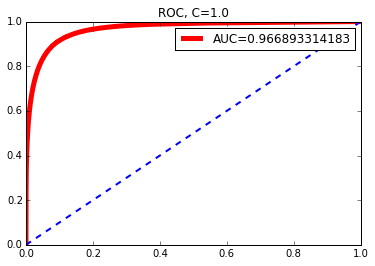

In [21]:
plot_ROC(LR_clf, test_X, test_y, LR_clf.get_params()["C"])

training under c= 0.5
plotting ROC
compute AUC


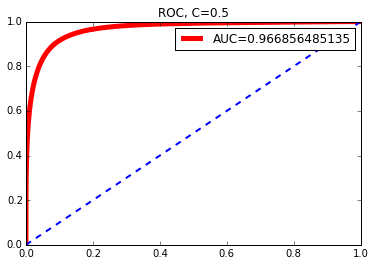


validation finished, with the highest acc:  0.907659298989  with C=  0.5


In [22]:
max_acc = 0
best_clf = None
max_C = 0
#c_pool = [0.01, 0.1, 0.5, 1.0, 10.0]
c_pool = [0.5]
for c in c_pool:
    print "training under c=", c
    tmp_LR_clf = LogisticRegression(C=c, n_jobs = use_cpu)
    train_clf_by_batches(tmp_LR_clf, train_X, train_y)
    tmp_test_labels = tmp_LR_clf.predict(validation_X)
    tmp_acc = np.sum([1 if y_truth == y_predict else 0 for y_truth, y_predict in zip(validation_y, tmp_test_labels)])*1.0/len(validation_y)
    
    if tmp_acc > max_acc:
        best_clf = tmp_LR_clf
        max_acc = tmp_acc
        max_C = c
    fig_new = plt.figure()
    plot_ROC(tmp_LR_clf, test_X, test_y, tmp_LR_clf.get_params()["C"])
print "validation finished, with the highest acc: ", max_acc, " with C= ", max_C
with open("best_clf_param.dat", "w") as f:
    pickle.dump((best_clf.coef_, best_clf.intercept_), f)



Accuracy:  0.91107498371
calibrated score (5-fold:) 0.225667403633
plotting ROC
compute AUC


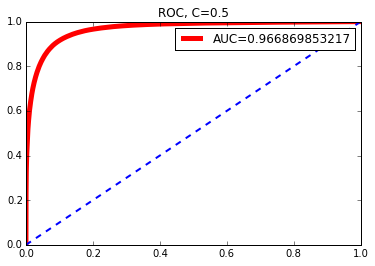


Brier Score: 0.0663818392683


In [23]:
clf_cv = CalibratedClassifierCV(best_clf, cv="prefit", method='isotonic')
#clf_cv = CalibratedClassifierCV(LR_clf, cv="prefit", method='isotonic')

train_clf_by_batches(clf_cv, validation_X, validation_y)
result_cv = clf_cv.predict(test_X)
acc = np.sum([1 if y_truth == y_predict else 0 for y_truth, y_predict in zip(test_y, result_cv)]).astype("float32")/len(test_y)
print "Accuracy: ", acc
probas_cv = clf_cv.predict_proba(test_X)
cv_score = log_loss(test_y, probas_cv)
print 'calibrated score (5-fold:)', cv_score
base_clf = clf_cv.get_params()["base_estimator"]
plot_ROC(clf_cv, test_X, test_y, base_clf.get_params()["C"])
with open("cv_clf_param.dat", "w") as f:
    pickle.dump((base_clf.coef_, base_clf.intercept_), f)
print "Brier Score:", brier_score_loss(test_y, probas_cv[:,1])